In [69]:
import os
import numpy as np
import struct
from numpy import zeros
import array
import matplotlib
from matplotlib import pyplot as plt
import scipy
from scipy import misc
import time
import sys
%matplotlib inline

In [2]:
def load_mnist(dataset="training", digits=np.arange(10), path=".", size = 60000):
    if dataset == "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset == "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = array.array("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = array.array("B", fimg.read())
    fimg.close()

    ind = [ k for k in range(size) if lbl[k] in digits ]
    N = size #int(len(ind) * size/100.)
    images = zeros((N, rows, cols), dtype='uint8')
    labels = zeros((N, 1), dtype='int8')
    for i in range(N): #int(len(ind) * size/100.)):
        images[i] = np.array(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ])\
            .reshape((rows, cols))
        labels[i] = lbl[ind[i]]
    labels = [label[0] for label in labels]
    return images, labels

In [3]:
tr,label = load_mnist("training")
tr_label = np.array(label,dtype = np.long)
te,te_label = load_mnist("testing")
te_label = np.array(te_label,dtype = np.long)

In [4]:
#scipy.misc.imread(d_tr)
def resize_data(dataset,size):
    rd = np.zeros((len(dataset),size,size))
    for img in range(len(dataset)):
        rd[img] = scipy.misc.imresize(dataset[img],(14,14))
    return rd

In [5]:
#resize the data set to 14*14
tr_14 = resize_data(tr,14)
te_14 = resize_data(te,14)

In [6]:
# import needed library for MLP 
import torch
import torch.nn as nn
import torch.nn.functional
import torch.utils.data
from torch.autograd import Variable

In [7]:
# generalize
tr = tr/256
te = te/256
tr_14 = tr_14/256
te_14 = te_14/256

In [8]:
# import dataset yo torch dataloader
train_data =torch.utils.data.DataLoader(torch.from_numpy(tr),batch_size = 100)
test_data =torch.utils.data.DataLoader(torch.from_numpy(te),batch_size = 100)
train_data_14 = torch.utils.data.DataLoader(torch.from_numpy(tr_14),batch_size = 100)
test_data_14 = torch.utils.data.DataLoader(torch.from_numpy(te_14),batch_size = 100)
train_label =torch.from_numpy(tr_label)
test_label = torch.from_numpy(te_label)

In [9]:

#calculate accuracy
def accuracy(preb,label):
    preb = preb.cpu().data.numpy()
    label = label.cpu().data.numpy()
    test_np = (np.argmax(preb,1)==label)
    test_np = np.float32(test_np)
    return (100*np.mean(test_np))

In [45]:
#build MLP add dropout
num_drop = 0.6
class MLP_28_dropout(nn.Module):
    def __init__(self):
        super(MLP_28_dropout, self).__init__()
        self.L1 = nn.Linear(784,512)
        self.drop1 = nn.Dropout(num_drop)
        self.L2 = nn.Linear(512,128)
        self.drop2 = nn.Dropout(num_drop)
        self.L3 = nn.Linear(128,10)
    def forward(self,din):
        din = din.view(-1,28*28)
        dout = torch.nn.functional.relu(self.drop1(self.L1(din)))
        dout = torch.nn.functional.relu(self.drop2(self.L2(dout)))
        return torch.nn.functional.softmax(self.L3(dout))
# without dropout
class MLP_28(nn.Module):
    def __init__(self):
        super(MLP_28, self).__init__()
        self.L1 = nn.Linear(784,512)
        self.L2 = nn.Linear(512,128)
        self.L3 = nn.Linear(128,10)
    def forward(self,din):
        din = din.view(-1,28*28)
        dout = torch.nn.functional.relu(self.L1(din))
        dout = torch.nn.functional.relu(self.L2(dout))
        return torch.nn.functional.softmax(self.L3(dout))

In [46]:
#dropout 14*14
class MLP_14_dropout(nn.Module):
    def __init__(self):
        super(MLP_14_dropout, self).__init__()
        self.L1 = nn.Linear(196,128)
        self.drop1 = nn.Dropout(num_drop)
        self.L2 = nn.Linear(128,49)
        self.drop2 = nn.Dropout(num_drop)
        self.L3 = nn.Linear(49,10)

    def forward(self,din):
        din = din.view(-1,14*14)
        dout = torch.nn.functional.relu(self.drop1(self.L1(din)))
        dout = torch.nn.functional.relu(self.drop2(self.L2(dout)))
        return torch.nn.functional.softmax(self.L3(dout))
#without dropout 14*14
class MLP_14(nn.Module):
    def __init__(self):
        super(MLP_14, self).__init__()
        self.L1 = nn.Linear(196,128)
        self.L2 = nn.Linear(128,49)
        self.L3 = nn.Linear(49,10)

    def forward(self,din):
        din = din.view(-1,14*14)
        dout = torch.nn.functional.relu(self.L1(din))
        dout = torch.nn.functional.relu(self.L2(dout))
        return torch.nn.functional.softmax(self.L3(dout))

In [77]:
input_data = train_data
input_label = train_label
momentum = 0.9
model = MLP_28().cuda()
sgd = torch.optim.SGD(model.parameters(),lr = 0.1, momentum = momentum)
lossfunc = torch.nn.CrossEntropyLoss()
trace = []
loss_list = []
trace_loss=[]
for n in range(100):
    sums = []
    for i,data in enumerate(input_data):
        sgd.zero_grad()
        data = data.type(torch.FloatTensor)
        labels = input_label[i*100:i*100+100].type(torch.LongTensor)
        inputs = torch.autograd.Variable(data).cuda()
        labels = torch.autograd.Variable(labels).cuda()
        outputs = model(inputs)
        loss = lossfunc(outputs,labels)
        loss_list.append(loss)
        loss.backward()
        sgd.step()
        sums.append(accuracy(outputs,labels))
    trace_loss.append(loss.data[0])
    sys.stdout.write('{0}/100\r'.format(n + 1))
    sys.stdout.flush()
    loss_list=[]
    trace.append(sum(sums)/len(sums))


In [59]:
# save model
torch.save(model,"MLP_28_withoutD_iteration_100.pt")

C:\Users\hu_ye\Anaconda3\lib\site-packages\torch\serialization.py:147: UserWarning: Couldn't retrieve source code for container of type MLP_28. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [62]:
model_l = torch.load('MLP_28_withoutD.pt')

In [63]:
input_data = test_data
input_label = test_label
momentum = 0.9
sgd = torch.optim.SGD(model.parameters(),lr = 0.1, momentum = momentum)
lossfunc = torch.nn.CrossEntropyLoss()
accuracy_list = []
for i,data in enumerate(test_data):
    data = data.type(torch.FloatTensor)
    labels = test_label[i*100:i*100+100].type(torch.LongTensor)
    inputs = torch.autograd.Variable(data).cuda()
    labels = torch.autograd.Variable(labels).cuda()
    outputs = model_l(inputs)
    accuracy_list.append(accuracy(outputs,labels))
print(sum(accuracy_list) / len(accuracy_list))

98.2600007057


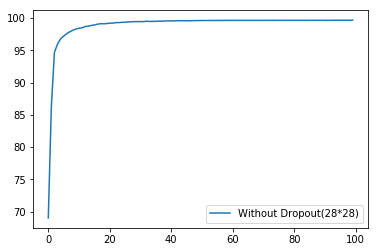

In [78]:
plt.plot(trace,label='Without Dropout(28*28)')
plt.legend(loc='lower right')

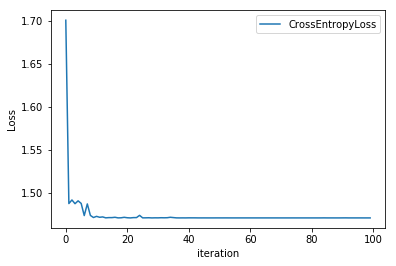

In [82]:
plt.plot(trace_loss,label='CrossEntropyLoss')
plt.ylabel('Loss')
plt.xlabel('iteration')
plt.legend(loc='upper right')
plt.savefig('CELoss_28_NoD_iter_100.png')